In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

from qrisp.operators import X, Y, Z
from qrisp.vqe.problems.heisenberg import *
import networkx as nx

import pickle
from time import time
from datetime import datetime

def save_data(data, filename):  
    # Open a file for writing
    with open(filename+'.pickle', 'wb') as file:
        # Write the object to the file
        pickle.dump(data, file)

def load_data(filename):
    with open(filename+'.pickle', 'rb') as file:
        # Load the object from the file
        data = pickle.load(file)
    return data

In [15]:
L = 10
G = nx.Graph()
G.add_edges_from([(k,(k+1)%L) for k in range(L-1)]) 

J = 1
B = 0.5
H = create_heisenberg_hamiltonian(G, J, B)

eigvals = scipy.sparse.linalg.eigs(H.to_array())
eigvals_from_low = np.sort(eigvals[0])
print(eigvals_from_low)
E0 = np.real(eigvals_from_low[0])
E1 = np.real(eigvals_from_low[1])
print('Target energy', E0)
print('First excited energy', E1)


[-17.03214083+1.76519604e-17j -16.72269436-8.26110407e-17j
 -15.72269436-6.01577574e-17j -15.10817429-2.22886837e-17j
 -14.72269436+2.88471455e-17j -14.10817429+6.79384930e-18j]
Target energy -17.032140829131546
First excited energy -16.722694358006475


In [ ]:
results = load_data('data/benchmarks03-18-18')

# QITE with Singlet and VQE warm start

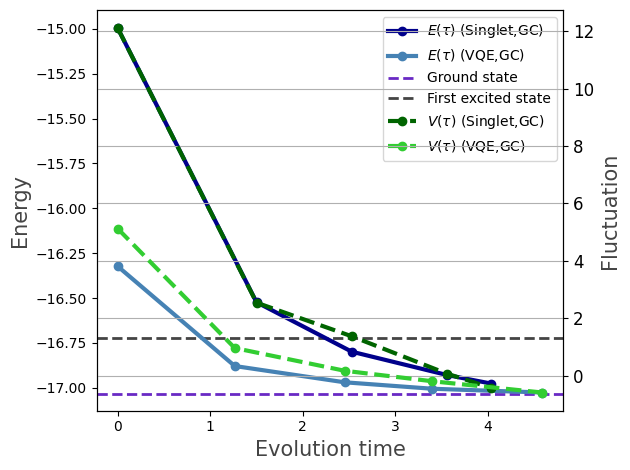

In [60]:

colors = ["#00008B", "#ADD8E6", "#006400", "#90EE90", "#8B0000", "#FFCCCB"]
blue_colors = ["#00008B", "#0000CD", "#4682B4", "#5F9EA0", "#87CEEB", "#ADD8E6"]
green_colors = ["#006400", "#228B22", "#32CD32", "#90EE90", "#98FB98", "#F0FFF0"]

lables_energies=["$E(\\tau)$ (Singlet,GC)","$E(\\tau)$ (Singlet,HOPF)","$E(\\tau)$ (VQE,GC)","$E(\\tau)$ (VQE,HOPF)"]
lables_fluctuations=["$V(\\tau)$ (Singlet,GC)","$V(\\tau)$ (Singlet,HOPF)","$V(\\tau)$ (VQE,GC)","$V(\\tau)$ (VQE,HOPF)"]

fig, ax1 = plt.subplots()

indices = [0,2] # GC
#indices = [1,3] # HOPF

# 1) Plot energies on the left y-axis
for i in indices:
    line1, = ax1.plot(results[i]['evolution_times'], results[i]['optimal_energies'], label=lables_energies[i], color=blue_colors[i], marker="o", linestyle='solid', linewidth=3, zorder=3)

ax1.axhline(y=E0, color='#6929C4', linestyle='--', linewidth=2, label='Ground state')
ax1.axhline(y=E1, color='#444444', linestyle='--', linewidth=2, label='First excited state')

ax1.set_xlabel("Evolution time", fontsize=15, color='#444444')
ax1.set_ylabel("Energy", fontsize=15, color='#444444')

# 2) Create a twin axis for fluctuations
ax2 = ax1.twinx()
for i in indices:
    line2, = ax2.plot(results[i]['evolution_times'], results[i]['variances'], label=lables_fluctuations[i], color=green_colors[i], marker="o", linestyle='dashed', linewidth=3, zorder=3)
ax2.set_ylabel("Fluctuation", fontsize=15, color='#444444')

# 3) Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

plt.tick_params(axis='both', labelsize=12)
plt.grid()
plt.tight_layout()
plt.savefig("QITE_rescaled_B=0.5_GC.pdf")
#plt.savefig("QITE_rescaled_B=0.5_HOPF.pdf")
plt.show()